# Scaling & Hyperparameter Tuning

![](https://i.ytimg.com/vi/b0L_2jKEbA4/maxresdefault.jpg)

Image description:
A cartoon illustration of the titanic disaster, the ship is shown to be sinking and there are people in the water and in a life boat. 
End of image description

In this notebook you will see a short example of how to scale your data and tune the hyperparamters of your models using grid or random search. 

We will use the well-known titanic dataset. Since you've already worked your way through the steps of exploring and cleaning the data as well as selecting proper features for modelling in another notebook, we will skip this part here and use the **preprocessed data** from the logistic regression notebook. 

In [2]:
# Import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer


from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

RSEED = 10

In [3]:
# Import data 
df = pd.read_csv('data/titanic_preprocessed.csv')
df.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,0,35.0,0,0,8.0500,1,0,1


In [4]:
# Check for missing data
df.isnull().sum()

Survived    0
Age         0
SibSp       0
Parch       0
Fare        0
male        0
Q           0
S           0
dtype: int64

## Train-test-split

We will define the target and predictors and split our dataset into a train and test set.

In [5]:
# Define predictors and target
y = df.Survived
X = df.drop('Survived', axis=1)

In [6]:
# Check X
X.head(2)

,Age,SibSp,Parch,Fare,male,Q,S
0,22.0,1,0,7.2500,1,0,1
1,38.0,1,0,71.2833,0,0,0


In [7]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---
## Feature Scaling

Often the input features of your model have different units which means that the variables also have different scales. While some model types (e.g. tree-based models like decision tree or random forest) are unaffected by the scale of numerical input variables, many machine learning algorithms including for example algorithms using distance measures (e.g. KNN, SVM) perform better when the input features are scaled to a specific range. 

The most popular techniques for scaling are **normalization** and **standardization**. 

Check the [link](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/) for further info. 

![](images/normalization_vs_standardization.png)

Image description:
Hand-drawn illustrations of the effects of different scaling methods on the same data.
The original data is a 2-dimensional scatter plot of 13 data points for two features, $X_1$ and $X_2$. $X_1$ is plotted on the horizontal axis and takes values ranging between 2 and 11. $X_2$ is plotted on the vertical axis and takes values ranging between 4 and 22. The plot is therefore about twice as tall as it is wide. 

The two scaling methods illustrated are Normalisation and Standardisation. 

In the normalised version of the same data, the same scatter plotted data has been compressed to fit inside a unit square with corners at the origin (0,0) and the opposite corner at (1,1). The formula for the process is also written out in the image. This way, e.g. the datapoint originally at (10,22) is now at approximately (0.9, 1) in the new scaled axes.

In the standardised version of the data, the scatterplot is now centred at the origin (0,0) and the datapoints are mostly in the interval (-2,2) on both axes, and the plot is more or less as tall as it is wide, but not as clearly square as for the normalised data. The formula for standardisation is also given on the image.

Both formulae are given further down below, so they are not repeated here in this image description.
End of image description

In [8]:
# Before we have a look at the different methods, 
# we have to define which columns we want to scale.
col_scale = ['Age', 'SibSp', 'Parch', 'Fare']

### Data Standardization 

In order to standardize a dataset it is necessary to rescale the distribution of values so that the mean of observed values is 0 and the standard deviation is 1. You can think of it as subtracting the mean value or centring the data. 
Sklearn provides us for this case with the [Standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

A value is standardized as follows: 

$ x_{scaled} = \frac{x – \mu}{\sigma}  $, where 

$ \mu = \frac{\sum{x}}{m} $ is the mean, where m is the number of observations

$ \sigma = \sqrt{ \frac{\sum{ (x – \mu)^2 }}{m}} $ is the standard deviation

In [9]:
# transformation with column transformer
scaling_transformation = ColumnTransformer([
    ('scaling', StandardScaler(), col_scale)],
    remainder='passthrough'
)

### Data normalization 

Normalizing the data means to rescale it from the original range so that all values lie within the new range of 0 and 1.
We can easily do this by using the [Min-Max-Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. This scaler transforms the feature(s) by scaling it(them) to a given range (default range is 0 to 1). 

A value is normalized as follows: 

$ x_{scaled} = \frac{x – x_{min}}{x_{max} – x_{min}} $

(Where the min and max values pertain to the value x being normalized, from your **train** dataset)

### ex1. Practice round
Try out doing normalizing

In [10]:
# Scaling with MinMaxScaler

# Try to scale you data with the MinMaxScaler() from sklearn. 
# It follows the same syntax as the StandardScaler.
# Don't forget: you have to import the scaler at the top of your notebook. 

### Bonus Question: Do the test standardized / normalized values follow the same properties of the train standardized / normalized values?

i.e standardized: centered on 0 with stdev of 1 / normalized w values between 0 and 1

---
## Predictive Modelling

We will evaluate our model performance with a quick and more reliable way using sklearn's [cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) which implements K-fold cross validation. When training a model based on train and test split we only have one experiment. Can we really trust one experiment? 

Think of [K-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) as doing K experiments and then taking the average error. It is still not perfect but better than 1 experiment which can randomly turn out to be really good. 

Whenever we have K, comes the question about the value of K.. common values are between 5 and 10 and you need to take into account the technical limitations: dataset size, compute power and available memory and time. CV takes time on large datasets.


![](images/cross_validation.png)

Image description:
A manually illustrated explanation of k-fold cross-validation.
The example given is for k=5, so we have five folds.
At the top, there is a rectangle representing a dataset. In the first step, this rectangle is split into 2 rectangles, one about 6 times smaller than the other. The longer part represents the training data and the shorter rectangle represents the test data.

After this visualisation of the train-test split, the test data disappears from the diagram (to illustrate the fact that we do not look at it again during training) and only the training subset of the data is pictured. 

The training data (shown as a long rectangle) is now split into 5 equally sized subsets (shorter rectangles), and the process for cross-validation is as follows:

One of the 5 folds of the data is selected as a validation subset, the rest form the training set for that fold. A model is trained and its performance on the unseen fold gives an error. There are five possible choices for the validation fold, so 5 models are trained in total, giving 5 errors. The final error is calculated as the mean of the errors of the individual models. 

At the end of the image there is a note that says: "Usage! Compare models"
End of image description

### KNNClassifier - unscaled data

In [11]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
knn_classifier = KNeighborsClassifier()
scores = cross_val_score(knn_classifier, X_train, y_train, cv=5, n_jobs=-1)

# Evaluation 
print('Score (unscaled):', round(scores.mean(), 2))
print('Standard Deviation (unscaled):', round(scores.std(), 2))

Score (unscaled): 0.69
Standard Deviation (unscaled): 0.02


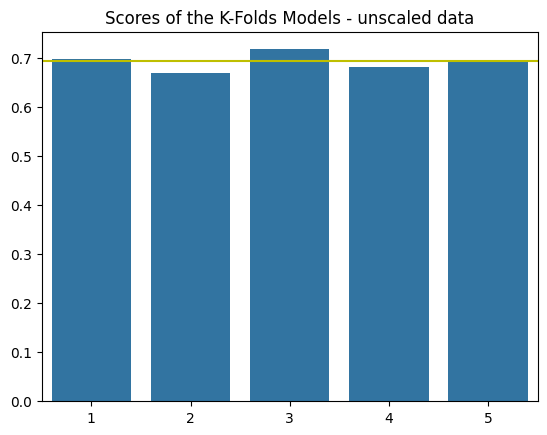

In [12]:
# plotting the scores and average score
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores).set_title('Scores of the K-Folds Models - unscaled data');

Image description:
Output of the bar plot comparing each of the 5 models trained during cross-validation and corresponding to the results given in the previous cell. The values fluctuate between around 0.67 and 0.72, and all the bars are generally of very similar heights. There is a horizontal line at the value which is the mean of the scores, i.e. 0.69. The plot is titled 'Scores of the K-Folds Models - unscaled data'.
End of image description

### KNNClassifier - scaled data

In [13]:
# Fit and evaluate model without hyperparameter tuning using cross validation and scaled data 
knn_classifier_scaled = Pipeline([
    ('scaling_trans', scaling_transformation ),
    ('knn',KNeighborsClassifier())
])
scores_scaled = cross_val_score(knn_classifier_scaled, X_train, y_train, cv=StratifiedKFold(5), n_jobs=-1)

# Evaluation
print('Score (scaled):', round(scores_scaled.mean(), 2))
print('Standard Deviation (unscaled):', round(scores.std(), 2))

Score (scaled): 0.78
Standard Deviation (unscaled): 0.02


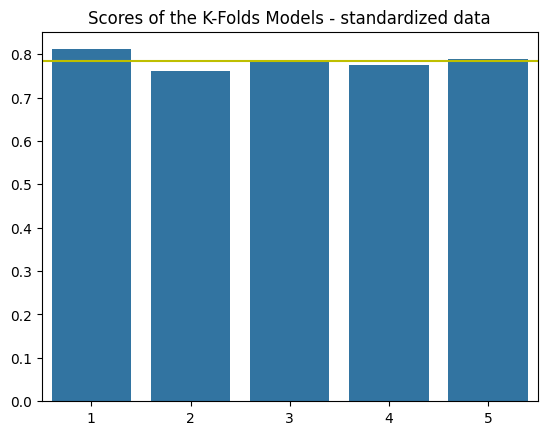

In [14]:
plt.axhline(y=scores_scaled.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores_scaled).set_title('Scores of the K-Folds Models - standardized data');

Image description:
Output of the bar plot comparing each of the 5 models trained during cross-validation and corresponding to the results given in the previous cell. The values fluctuate between around 0.75 and 0.81, so there has obviously been some improvement. Still, all the bars are generally of very similar heights. There is a horizontal line at the value which is the mean of the scores, i.e. 0.78. The plot is titled 'Scores of the K-Folds Models - standardized data'.
End of image description

You can see that the overall error has gone down significantly (in my case an increase of 13% in the evaulation score), but the errors of the folds are rather similar to each. To show the effect of scaling a bit clearer we will look at another classifier that is even more affected by it.  

### SGDClassifier - unscaled data

SGD classifier stands for stochastic gradient descent classifier and implements a variety of classifiers - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM). We will use it here to further emphasise the importance of scaling and will set the loss parameter to `log_loss`. This way the model will be a logistic regression using stochastic gradient descent for learning.

In [15]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
sgd_classifier = SGDClassifier(random_state=RSEED, loss ='log_loss')
scores = cross_val_score(sgd_classifier, X_train, y_train, cv=StratifiedKFold(5), n_jobs=-1)

# Evaluation 
print('Score (unscaled):', round(scores.mean(), 2))
print('Standard Deviation (unscaled):', round(scores.std(), 2))

Score (unscaled): 0.71
Standard Deviation (unscaled): 0.05


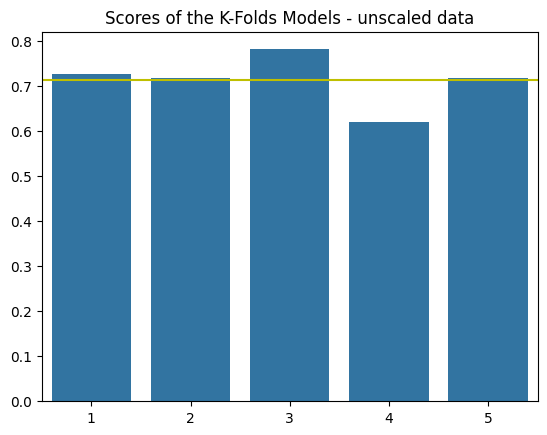

In [16]:
# plotting the scores and average score
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores).set_title('Scores of the K-Folds Models - unscaled data');

Image description:
Bar plot comparing each of the 5 models trained during cross-validation and corresponding to the results given in the previous cell. The values fluctuate between around 0.47 and 0.78, so there is a lot of variability in how the individual models perform. There is a horizontal line at the value which is the mean of the scores, i.e. 0.64. The plot is titled 'Scores of the K-Folds Models - unscaled data'.
End of image description

The validation error varies a lot for the different folds of the data (from around 0.5 to a high of almost 0.8)

In [17]:
# Fit and evaluate model without hyperparameter tuning using cross validation and scaled data 
sgd_classifier_scaled = Pipeline([
    ('scaling_trans', scaling_transformation ),
    ('sgd', SGDClassifier(random_state=RSEED,loss ='log_loss'))

])

scores_scaled = cross_val_score(sgd_classifier_scaled, X_train, y_train, cv=StratifiedKFold(5), n_jobs=-1)

# Evaluation
print('Score (scaled):', round(scores_scaled.mean(), 2))
print('Standard Deviation (unscaled):', round(scores_scaled.std(), 2))

Score (scaled): 0.78
Standard Deviation (unscaled): 0.02


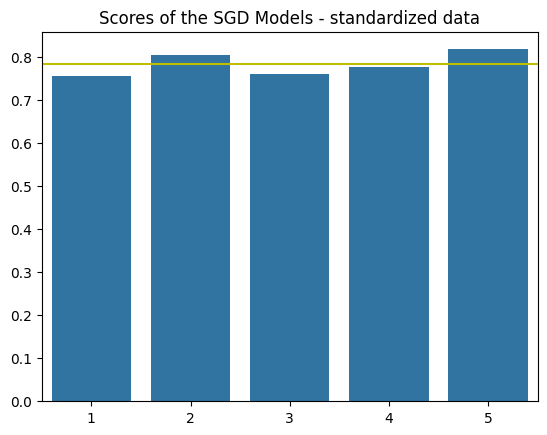

In [18]:
plt.axhline(y=scores_scaled.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores_scaled).set_title('Scores of the SGD Models - standardized data');

Image description:
Bar plot comparing each of the 5 models trained during cross-validation and corresponding to the results given in the previous cell. The values fluctuate between around 0.76 and 0.84, and are of similar heights, so the variability in how the individual models perform has been addressed by the scaling. There is a horizontal line at the value which is the mean of the scores, i.e. 0.78. The plot is titled 'Scores of the SGD Models - standardized data'.
End of image description

Beside the obviously better overall performance an important effect of scaling visible here is that the validation error doesn't vary quite as much as it used with most of the values being closer to the 0.8 mark. 

### ex2. Practice round
Try out KNNClassifier with the normalized data

In [19]:
# Train model using the MinMaxScaler data you scaled in ex1.

# It follows the same syntax as the StandardScaler.

---
## Hyperparameter Tuning

Most models have many hyperparameters that work better with some datasets than with others. Same goes with the hyperparameters from regularization which we learned that are selected based on a trial and error process. So how do we manage to select the parameter values that work best for our data?

#### GridSearchCV

[Grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is a tuning technique that attempts to compute the optimum values of hyperparameters. It performs an exhaustive search over a prior defined parameter space using cross-validation (hence the **CV** suffix). That means it will evaluate all of the possible parameter combinations of the search space in order to find and return the best combination. 


This task, however, starts to become very time-consuming if there are many hyperparameters and the search space is huge. As you can see for k= 5 and for 2 parameters with 2, and respectively 3 values, thus 6 combinations, the GridSearchCV runs 30 modelling steps in order to just come up with the best values for the two parameters.

![](images/grid_search_cv.png)

Image description:
A hand drawn image of GridSearch + Cross Validation process. 
The cross-validation part is the same as in the image above (showing the 5 fold cross validation process). Additionally there are now two hyperparameters, $a$ and $b$, which can take the values a = 1, 2 or 3 and b = 1 or 2. There is a table showing all the possible combinations of a and b of which there are 6. There is a loop drawn between the hyperparameter combinations, the cross-validation diagram, and finally a model, followed by the words "winner parameter combination". 

There is also text saying "6 x 5 = 30 trained models", referring to the fact that for each of the 6 possible combinations of a and b in this example, there are 5 models trained in total during the cross-validation process.


End of image description

In [20]:
#what hyperparameters does KNN have?
knn_classifier_scaled.get_params()

{'memory': None,
 'steps': [('scaling_trans',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('scaling', StandardScaler(),
                                    ['Age', 'SibSp', 'Parch', 'Fare'])])),
  ('knn', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'scaling_trans': ColumnTransformer(remainder='passthrough',
                   transformers=[('scaling', StandardScaler(),
                                  ['Age', 'SibSp', 'Parch', 'Fare'])]),
 'knn': KNeighborsClassifier(),
 'scaling_trans__force_int_remainder_cols': 'deprecated',
 'scaling_trans__n_jobs': None,
 'scaling_trans__remainder': 'passthrough',
 'scaling_trans__sparse_threshold': 0.3,
 'scaling_trans__transformer_weights': None,
 'scaling_trans__transformers': [('scaling',
   StandardScaler(),
   ['Age', 'SibSp', 'Parch', 'Fare'])],
 'scaling_trans__verbose': False,
 'scaling_trans__verbose_feature_names_out': True,
 'scaling_trans__scaling': StandardScaler(),
 's

In [21]:
# Defining parameter grid (as dictionary)
param_grid = {"knn__n_neighbors" : [2,4,3,5,10], #this actually defines the model you use
              "knn__weights" : ["uniform", "distance"],
              "knn__p" : [1, 2, 3],
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(knn_classifier_scaled, param_grid, scoring='accuracy',
                  cv=5, verbose=1, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
start = timer()
gs.fit(X_train, y_train)
end = timer()
gs_time = end-start

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [22]:
gs_time

1.0622176250035409

In [23]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.786
Best parameters: {'knn__n_neighbors': 5, 'knn__p': 3, 'knn__weights': 'uniform'}


In [24]:
# we will do this at least twice.. according to DRY we should write a function
def print_pretty_summary(name, best_model, y_test, y_pred_test):
    print(name)
    print('=======================')
    print('n_neighbors: {}'.format(best_model.steps[-1][1].n_neighbors))
    print('weights: {}'.format(best_model.steps[-1][1].weights))
    print('p: {}'.format(best_model.steps[-1][1].p))
    print('algorithm: {}'.format(best_model.steps[-1][1].algorithm))

    accuracy = accuracy_score(y_test, y_pred_test)
    print('Test accuracy: {:2f}'.format(accuracy))
    return accuracy

In [25]:
knn_best = gs.best_estimator_
knn_best

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaling_trans', ...), ('knn', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scaling', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

In [26]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best = gs.best_estimator_

# Making predictions on the test set
y_pred_test = knn_best.predict(X_test)
# Let us print out the performance of our model on the test set.
knn_accuracy = print_pretty_summary('KNNClassifier model', knn_best, y_test, y_pred_test)

KNNClassifier model
n_neighbors: 5
weights: uniform
p: 3
algorithm: auto
Test accuracy: 0.764045


#### [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

As an alternative to grid search we can use sklearn's RandomizedSearchCV(). Random search will not try every possible combination of our search space but will randomly pick and evaluate parameter combinations. 

In [27]:
# Define parameter grid for randomized search
param_grid = {"knn__n_neighbors" : [2,4,3,5,10], #this actually defines the model you use
              "knn__weights" : ["uniform", "distance"],
              "knn__p" : [1, 2, 3],
             }
# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(knn_classifier_scaled, param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, random_state=RSEED)

# Fit randomized search object to data
start = timer()
rs.fit(X_train, y_train)
end = timer()
rgs_time = end-start

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END knn__n_neighbors=5, knn__p=2, knn__weights=uniform;, score=0.811 total time=   0.0s
[CV 2/5] END knn__n_neighbors=5, knn__p=2, knn__weights=uniform;, score=0.761 total time=   0.0s
[CV 3/5] END knn__n_neighbors=5, knn__p=2, knn__weights=uniform;, score=0.782 total time=   0.0s
[CV 4/5] END knn__n_neighbors=5, knn__p=2, knn__weights=uniform;, score=0.775 total time=   0.0s
[CV 1/5] END knn__n_neighbors=4, knn__p=1, knn__weights=distance;, score=0.769 total time=   0.0s
[CV 5/5] END knn__n_neighbors=5, knn__p=2, knn__weights=uniform;, score=0.789 total time=   0.0s
[CV 3/5] END knn__n_neighbors=4, knn__p=1, knn__weights=distance;, score=0.746 total time=   0.0s
[CV 2/5] END knn__n_neighbors=4, knn__p=1, knn__weights=distance;, score=0.746 total time=   0.0s
[CV 4/5] END knn__n_neighbors=4, knn__p=1, knn__weights=distance;, score=0.754 total time=   0.0s
[CV 5/5] END knn__n_neighbors=4, knn__p=1, knn__weights=distan

In [28]:
# Best score
print('Best score:', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)

Best score: 0.783
Best parameters: {'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 5}


In [29]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = knn_best_rs.predict(X_test)


# Let us print out the performance of our model on the test set.
rknn_accuracy = print_pretty_summary('KNNClassifier model (randomizedGSCV)', knn_best_rs, y_test, y_pred_test_rs)

KNNClassifier model (randomizedGSCV)
n_neighbors: 5
weights: uniform
p: 2
algorithm: auto
Test accuracy: 0.769663


In [30]:
print(f"Grid search took {gs_time} seconds to run with accuracy: {knn_accuracy:f}")
print(f"Randomized Grid search took {rgs_time} seconds to run with accuracy: {rknn_accuracy:f}")

Grid search took 1.0622176250035409 seconds to run with accuracy: 0.764045
Randomized Grid search took 0.08189437497640029 seconds to run with accuracy: 0.769663


This is an educational example... more data means longer train times